# Part 4 Solve the equations (neglict ci)

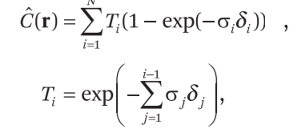

## import libraries

In [91]:
"""
Re‑creates your current world + camera demo and opens a matplotlib window.
Run:  python -m examples.demo_world
"""
import numpy as np
from nerflab import (
    Intrinsics, Camera, Box, Sphere, World, cartesian_to_spherical,
    stratified_samples_batch, plot_world, CFG, pose_H, make_pose_cases
)


In [92]:
# build preset dictionary
cases = make_pose_cases(axis_dist=10)

# pick a view (e.g., diagonal)
H_wc = pose_H(cases["+Z"])  
print(H_wc)

[[ 1.  0. -0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1. 10.]
 [ 0.  0.  0.  1.]]


In [ ]:
# --- camera ------------------------------------------------------------------
intr  = Intrinsics(**CFG.intrinsics.__dict__)
cam   = Camera(intr, H_wc,
               t_bounds=(CFG.rays.t_near, CFG.rays.t_far))

# --- sample rays -------------------------------------------------------------
O_w, D_w = cam.get_rays(frame="world")
t, delta, pts = stratified_samples_batch(
    O_w, D_w, CFG.rays.t_near, CFG.rays.t_far,
    N=CFG.rays.N, deterministic=CFG.rays.deterministic
)
print("points shape:", pts.shape)

# Angles
_, theta, phi = cartesian_to_spherical(pts)
# --- visualise ---------------------------------------------------------------




points shape: (307200, 20, 3)
